# Example optimisation with stochastic nonlocal modifications and gradient descent

## TODO

- [ ] Split out cost calc entirely?
- [ ] Double-check RNG handling!
- [ ] remove duplicates from population?
- [ ] remove duplicates of r0 from population?
- [ ] mix in r0 everytime
- [ ] reduce cache size?
- [ ] allow for increased cost along the way?
- [ ] only use single mod steps in stochastic search and go for more gens?

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import time

tic = time.time()

In [3]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.convenience import (
    create_route,
    stochastic_search,
    gradient_descent,
    Logs,
    LogsRoute,
)
from ship_routing.algorithms import (
    crossover_routes_minimal_cost,
    crossover_routes_random,
)

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm
import random
import xarray as xr
import shapely
from functools import partial

## Parameters

In [5]:
# ambient data sources
current_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_mod_glo_phy_my_0.083deg_P1D-m_time_2021_lat_+10_+65_lon_-100_+010_uo-vo.zarr/"
wave_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_mod_glo_wav_my_0.2deg_PT3H-i_time_2021_lat_+10_+65_lon_-100_+010_VHM0-VMDR.zarr/"
wind_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_time_2021_lat_+10_+65_lon_-100_+010_eastward_wind-northward_wind.zarr/"

# reproducibility / randomness
random_seed = 345
experiment_id = 2

# journey
lon_waypoints = [-80.5, -12.0]
lat_waypoints = [30.0, 45.0]
time_start = "2021-08-01T12:00"
time_end = None
speed_knots = 12.0  # either one time and speed or both times needed
time_resolution_hours = 6.0

# global parameters
population_size = 512
number_generations = 5

# mutation parameters
mutation_number_per_generation = 3
mutation_max_width_percent = 100
mutation_max_move_percent = 10
mutation_prefer_short_scales = True

# selection paramters
selection_pairwise_use = True
selection_pairwise_mixin = 0.0
selection_pairwise_nsteps = 4
selection_global_use = True
selection_global_threshold_quantile = 0.3
selection_global_mixin = 0.1

# crossover parameters
crossover_random_use = True
crossover_random_number_per_generation = 2
crossover_minimal_use = True
crossover_minimal_number_per_generation = 2

## RNG

In [6]:
np.random.seed(random_seed)
rsq = np.random.SeedSequence()

## Define a route

In [7]:
route_0 = create_route(
    lon_waypoints=lon_waypoints,
    lat_waypoints=lat_waypoints,
    time_start=time_start,
    time_end=time_end,
    speed_knots=speed_knots,
    time_resolution_hours=time_resolution_hours,
)

route_0

Route(way_points=(WayPoint(lon=np.float64(-80.5), lat=np.float64(30.0), time=np.datetime64('2021-08-01T12:00:00')), WayPoint(lon=-79.38446489132751, lat=30.70138430219714, time=np.datetime64('2021-08-01T17:57:38.608')), WayPoint(lon=-78.25278989826282, lat=31.392972719401122, time=np.datetime64('2021-08-01T23:55:17.217')), WayPoint(lon=-77.10452699236302, lat=32.07435318052685, time=np.datetime64('2021-08-02T05:52:55.826')), WayPoint(lon=-75.93923933796691, lat=32.74510208764611, time=np.datetime64('2021-08-02T11:50:34.434')), WayPoint(lon=-74.75650374725458, lat=33.40478430770569, time=np.datetime64('2021-08-02T17:48:13.043')), WayPoint(lon=-73.55591336477116, lat=34.05295323279573, time=np.datetime64('2021-08-02T23:45:51.652')), WayPoint(lon=-72.33708058614387, lat=34.689150917615144, time=np.datetime64('2021-08-03T05:43:30.260')), WayPoint(lon=-71.09964021294728, lat=35.31290830322864, time=np.datetime64('2021-08-03T11:41:08.869')), WayPoint(lon=-69.84325284228076, lat=35.9237455365

In [8]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 6.173339258297918


## Load and plot currents, winds, waves

In [9]:
currents = load_currents(
    data_file=current_data_store,
    engine="zarr",
    chunks="auto",
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.HashableDataset> Size: 4GB
Dimensions:  (lat: 661, lon: 1321, time: 365)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    uo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    vo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    speed    (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>

In [10]:
winds = load_winds(
    data_file=wind_data_store,
    engine="zarr",
    chunks="auto",
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds = winds

In [11]:
waves = load_waves(
    data_file=wave_data_store,
    engine="zarr",
    chunks="auto",
)

waves = waves

## Subset for the route

In [12]:
%time currents = currents.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time winds = winds.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time waves = waves.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()

CPU times: user 536 ms, sys: 266 ms, total: 802 ms
Wall time: 507 ms
CPU times: user 6.17 s, sys: 7.07 s, total: 13.2 s
Wall time: 1.51 s
CPU times: user 101 ms, sys: 40.4 ms, total: 141 ms
Wall time: 66.2 ms


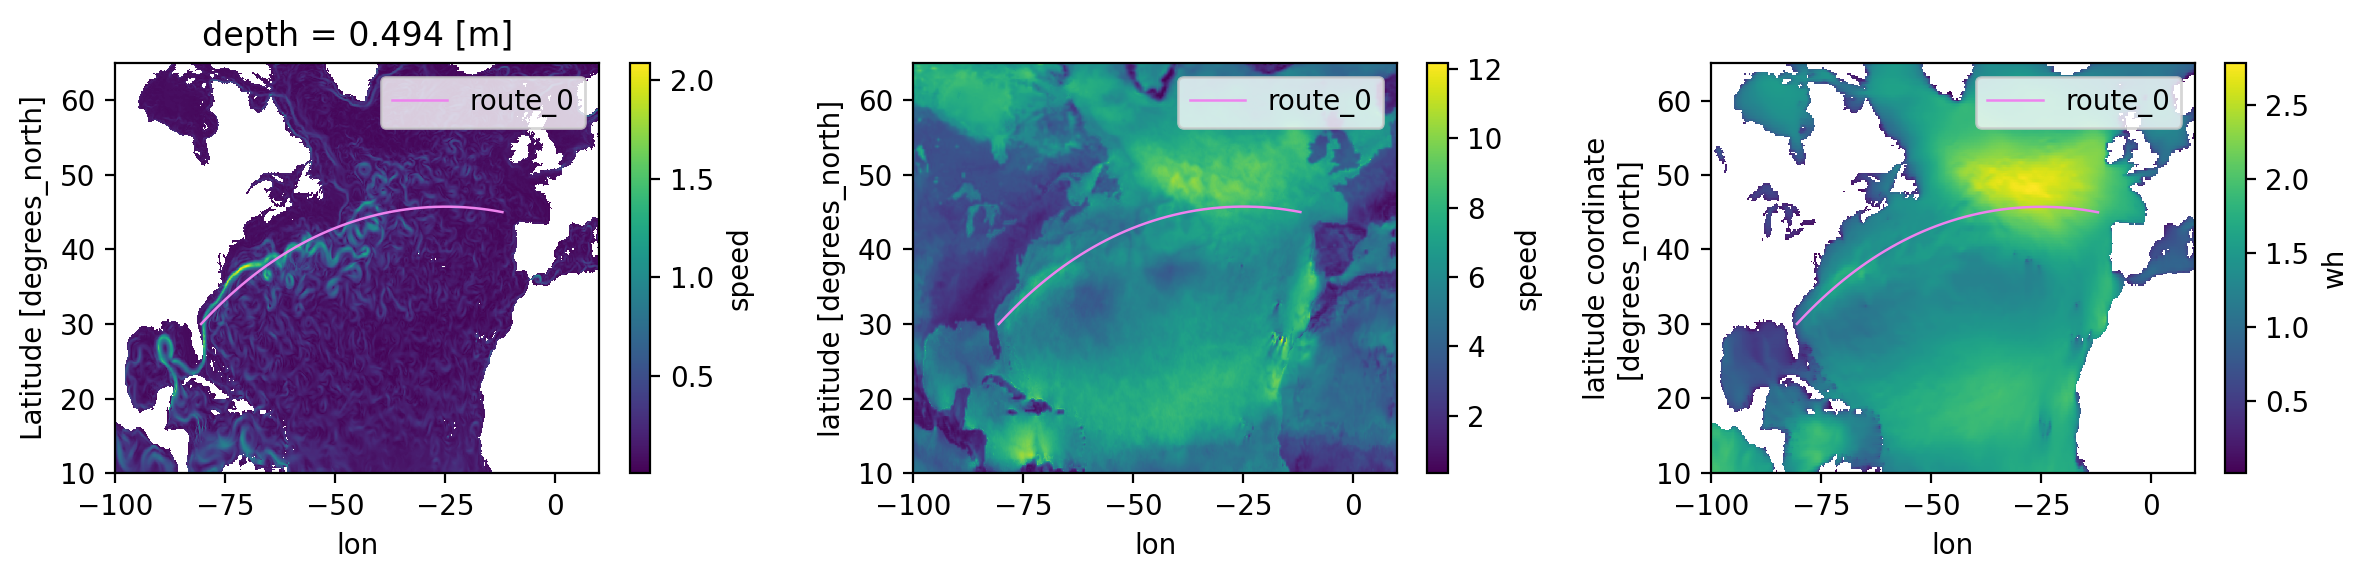

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon",
        y="lat",
        ax=_ax,
        color="violet",
        label="route_0",
        linewidth=0.9,
    )

fig.tight_layout();

## Concurrency

In [14]:
from concurrent.futures import ProcessPoolExecutor

In [15]:
def distribute_ambient_fields(currents_in=None, winds_in=None, waves_in=None):
    global currents
    global winds
    global waves
    currents = currents_in
    winds = winds_in
    waves = waves_in

In [16]:
def mod_route(
    rc, max_width_percent=None, max_move_percent=30, prefer_short_scales=True
):
    route = rc[0]
    route_length = route.length_meters

    # decide about modification length
    if max_width_percent is not None:
        max_mod_width = route_length * max_width_percent / 100.0
    else:
        max_mod_width = route_length
    if prefer_short_scales:
        mod_width = (np.random.uniform(0, 1) ** 1.5) * max_mod_width
    else:
        mod_width = np.random.uniform(0, 1) * max_mod_width

    # decide about modification location
    center_distance_meters = np.random.uniform(
        mod_width / 2.0, route_length - mod_width / 2.0
    )

    # decide about move distance (including sign)
    max_move_meters = mod_width * max_move_percent / 100.0
    if prefer_short_scales:
        move_meters = (
            max_move_meters
            * ((-1) ** np.random.randint(0, 2))
            * (np.random.uniform(0, 1) ** 1.5)
        )
    else:
        move_meters = (
            max_move_meters
            * ((-1) ** np.random.randint(0, 2))
            * np.random.uniform(0, 1)
        )

    return (
        route.move_waypoints_left_nonlocal(
            center_distance_meters=center_distance_meters,
            width_meters=mod_width,
            max_move_meters=move_meters,
        ),
        np.nan,
    )

In [17]:
def calc_cost(rc, current_data_set=None, wind_data_set=None, wave_data_set=None):
    global currents
    global winds
    global waves
    try:
        cost = rc[0].cost_through(
            current_data_set=currents, wind_data_set=winds, wave_data_set=waves
        )
        return (rc[0], cost)
    except:
        return (rc[0], np.nan)

In [18]:
def select_cheaper(rc0, rc1, mixin=0):
    if np.random.random() < mixin:
        return rc0
    if rc0[1] < rc1[1]:
        return rc0
    else:
        return rc1

In [19]:
def select_global(population, threshold_quantile=None, global_mixin=0):
    cost = [p[1] for p in population]
    threshold = np.quantile(np.array(cost), q=threshold_quantile)
    selected = [
        p for p in population if (p[1] <= threshold) or (random.random() < global_mixin)
    ]
    return selected

In [20]:
def filter_valid(population):
    return [p for p in population if not np.isnan(p[1])]


def fill_up(population, target_size=0):
    return population + list(
        random.choices(population, k=max(0, target_size - len(population)))
    )

In [21]:
def crossover_rand(rc0, rc1):
    try:
        return (crossover_routes_random(rc0[0], rc1[0]), np.nan)
    except:
        return (rc0, np.nan)

In [22]:
def crossover_min(rc0, rc1):
    global currents
    global winds
    global waves
    try:
        r = crossover_routes_minimal_cost(
            rc0[0],
            rc1[0],
            current_data_set=currents,
            wind_data_set=winds,
            wave_data_set=waves,
        )
        c = r.cost_through(
            current_data_set=currents,
            wind_data_set=winds,
            wave_data_set=waves,
        )
        return (r, c)
    except:
        if np.random.random() < 0.5:
            return rc0
        else:
            return rc1

In [23]:
cost_0 = route_0.cost_through(
    current_data_set=currents, wind_data_set=winds, wave_data_set=waves
)
rc0 = (route_0, cost_0)

In [24]:
import os


def seed_rng(seed):
    time.sleep(1)
    np.random.seed(seed)
    return (os.getpid(), seed, np.random.random())


def test_rng(n):
    time.sleep(1)
    return (os.getpid(), n, np.random.random())

In [25]:
population = [rc0 for _ in range(population_size)]

In [26]:
%%time

generations = [
    deepcopy(population),
]

n_workers = 32

with ProcessPoolExecutor(
    n_workers, initializer=distribute_ambient_fields, initargs=(currents, winds, waves)
) as executor:

    rand = list(executor.map(seed_rng, rsq.generate_state(n_workers)))
    rand2 = list(executor.map(test_rng, range(n_workers)))

    for ngen in range(number_generations):

        # mutations
        for nmod in range(mutation_number_per_generation):
            population = list(
                tqdm.tqdm(
                    executor.map(
                        partial(
                            mod_route,
                            max_width_percent=mutation_max_width_percent,
                            max_move_percent=mutation_max_move_percent,
                            prefer_short_scales=mutation_prefer_short_scales,
                        ),
                        population,
                    ),
                    total=population_size,
                    desc=f"MD-{ngen}-{nmod}",
                )
            )

        # calc cost
        population = list(
            tqdm.tqdm(
                executor.map(calc_cost, population),
                total=population_size,
                desc=f"CC-{ngen}",
            )
        )
        population = filter_valid(population)
        population = fill_up(population, target_size=population_size)

        generations.append(deepcopy(population))

        # selection pairwise
        if selection_pairwise_use:
            for nsel in range(selection_pairwise_nsteps):
                population = list(
                    tqdm.tqdm(
                        map(
                            partial(select_cheaper, mixin=selection_pairwise_mixin),
                            population,
                            random.choices(population, k=population_size),
                        ),
                        total=population_size,
                        desc=f"SL-{ngen}-{nsel}",
                    )
                )

        generations.append(deepcopy(population))

        # crossover minimal
        if crossover_minimal_use:
            for ncross in range(crossover_random_number_per_generation):
                population = list(
                    tqdm.tqdm(
                        executor.map(
                            crossover_min,
                            population,
                            random.choices(population, k=population_size),
                        ),
                        total=population_size,
                        desc=f"CM-{ngen}-{ncross}",
                    )
                )
                population = filter_valid(population)
                population = fill_up(population, target_size=population_size)

        generations.append(deepcopy(population))

        # selection global
        if selection_global_use:
            population = select_global(
                population,
                threshold_quantile=selection_global_threshold_quantile,
                global_mixin=selection_global_mixin,
            )
        population = fill_up(population, target_size=population_size)

        generations.append(deepcopy(population))

        # crossover random
        if crossover_random_use:
            for ncross in range(crossover_random_number_per_generation):
                population = list(
                    tqdm.tqdm(
                        executor.map(
                            crossover_rand,
                            population,
                            random.choices(population, k=population_size),
                        ),
                        total=population_size,
                        desc=f"CR-{ngen}-{ncross}",
                    )
                )

        # calc cost
        population = list(
            tqdm.tqdm(
                executor.map(calc_cost, population),
                total=population_size,
                desc=f"CC-{ngen}",
            )
        )
        population = filter_valid(population)
        population = fill_up(population, target_size=population_size)

        generations.append(deepcopy(population))

CM-0-1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:31<00:00, 16.28it/s]


CR-0-0


CR-0-0: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 140.15it/s]


CR-0-1


CM-1-1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:40<00:00, 12.79it/s]


CR-1-0


CR-1-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 92.59it/s]


CR-1-1


CM-2-1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:57<00:00,  8.90it/s]


CR-2-0


CR-2-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:09<00:00, 53.55it/s]


CR-2-1


CM-3-1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:22<00:00,  6.23it/s]


CR-3-0


CR-3-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:14<00:00, 34.32it/s]


CR-3-1


CM-4-1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:19<00:00,  6.44it/s]


CR-4-0


CR-4-0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:17<00:00, 28.77it/s]


CR-4-1


CC-4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:30<00:00, 16.85it/s]


CPU times: user 24 s, sys: 4 s, total: 28 s
Wall time: 15min 48s


In [27]:
len(population), len(generations)

(512, 26)

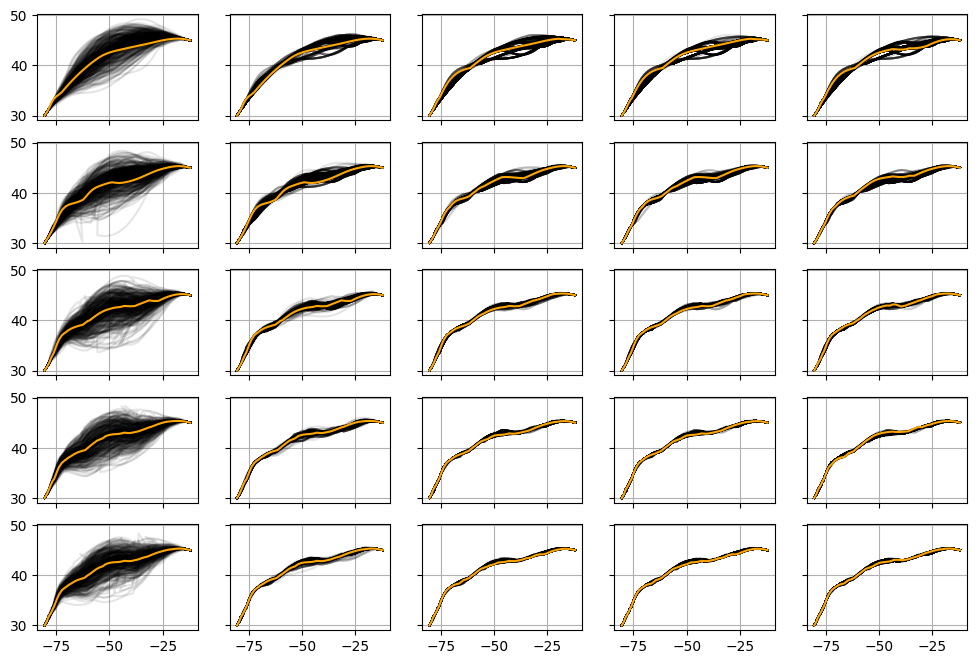

In [41]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(12, 8))

for g, _ax in zip(generations[1:], ax.flatten()):
    for p in g:
        _ax.plot(*p[0].line_string.xy, "k-", alpha=0.1)
    _best = g[np.argmin([p[1] for p in g])][0]
    _ax.plot(*_best.line_string.xy, color="orange", alpha=1.0)
    _ax.grid();

In [46]:
_cc = np.array([[p[1] for p in g] for g in generations])
_bins = np.linspace(0.75, 1.15, 51);

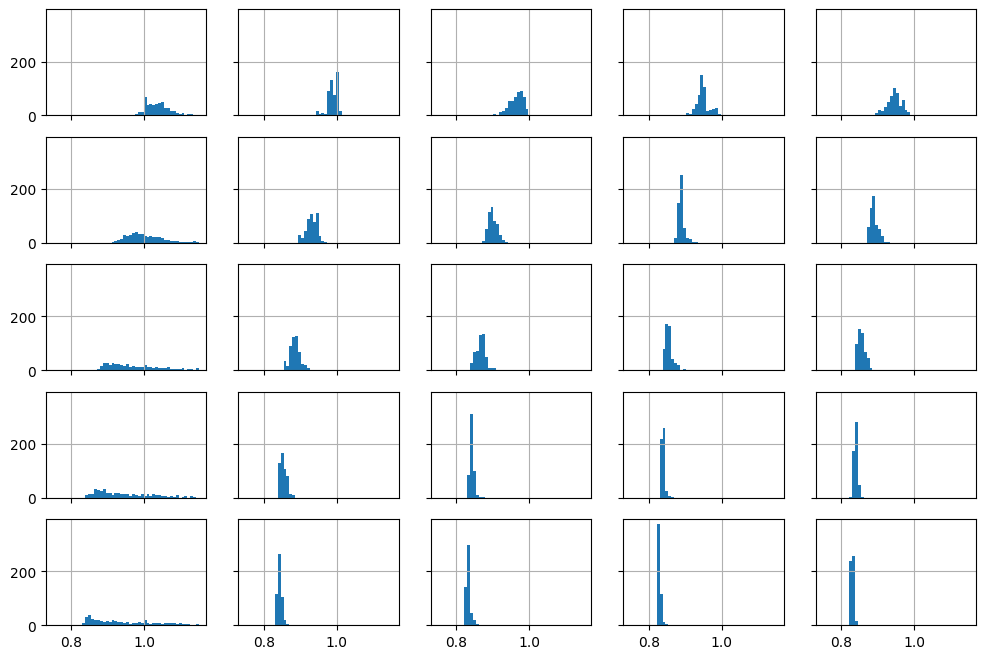

In [47]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(12, 8))

for g, _ax in zip(generations[1:], ax.flatten()):
    _ax.hist([p[1] / cost_0 for p in g], bins=_bins)
    _ax.grid();

<Axes: >

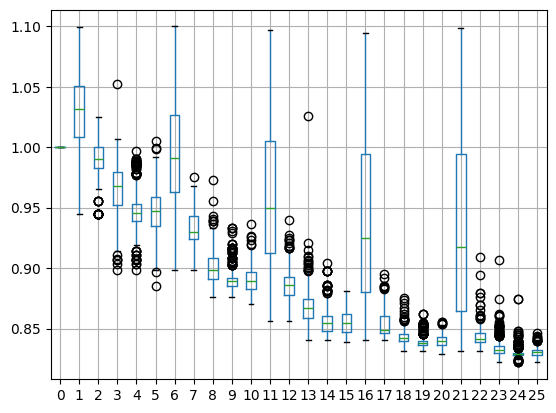

In [48]:
cost = pd.DataFrame(np.array([[p[1] for p in g] for g in generations]).T) / cost_0
cost = cost.where(cost < 1.1)  # .fillna(1.1)
cost.boxplot()